# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False, progress=True)
sim.print_trace_results()

100%|██████████| 1000000/1000000 [00:50<00:00, 19815.83it/s]
Cold Starts / total requests: 	 1181 / 901572
Cold Start Probability: 	 0.0013
Rejection / total requests: 	 0 / 901572
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6546.5765
Average Server Count:  		 7.6923
Average Running Count:  	 1.7949
Average Idle Count:  		 5.8974


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()
skip_init = sim.get_skip_init(skip_init_time=100)

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_index=skip_init)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_index=skip_init)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(12, 'u')       0.0012
(7, 'u')        0.1246
(13, 'd')       0.0000
(8, 'd')        0.0523
(9, 'u')        0.1302
(13, 'u')       0.0000
(8, 'u')        0.3330
(6, 'u')        0.0000
(9, 'd')        0.0047
(11, 'd')       0.0000
(10, 'u')       0.0229
(6, 'd')        0.0545
(14, 'u')       0.0006
(11, 'u')       0.0030
(10, 'd')       0.0004
(12, 'd')       0.0000
(5, 'd')        0.0001
(7, 'd')        0.2726


,state,prob,sojourn_time
16,"(5, d)",9.671361e-05,96.703938
11,"(6, d)",5.447707e-02,198.801550
7,"(6, u)",9.113817e-07,0.911291
17,"(7, d)",2.726188e-01,459.682171
1,"(7, u)",1.246144e-01,454.751730
3,"(8, d)",5.227672e-02,213.353039
6,"(8, u)",3.329711e-01,560.501390
8,"(9, d)",4.680266e-03,101.734729
4,"(9, u)",1.301944e-01,531.295931
14,"(10, d)",4.087254e-04,51.085566


## Calculate Average Transition Times

In [4]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_index=skip_init)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
24,"(5, d)","(6, u)",1,96.703938,1,1.000000
3,"(6, d)","(7, u)",273,199.159465,274,0.996350
23,"(6, d)","(5, d)",1,101.090916,274,0.003650
25,"(6, u)","(7, u)",1,0.911291,1,1.000000
1,"(7, d)","(8, u)",363,514.105094,593,0.612142
2,"(7, d)","(6, d)",230,373.788601,593,0.387858
4,"(7, u)","(8, u)",230,348.264827,274,0.839416
8,"(7, u)","(6, d)",44,1011.387816,274,0.160584
7,"(8, d)","(7, d)",233,207.060481,245,0.951020
12,"(8, d)","(9, u)",12,335.533534,245,0.048980


## Calculate Transition Time Histograms

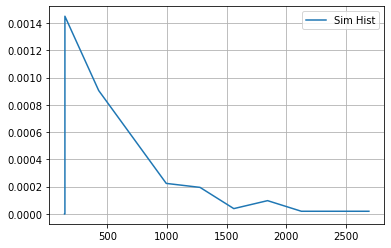

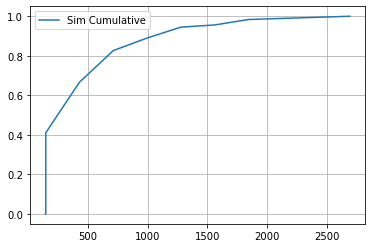

In [5]:
from pacssim.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Cold Start Probabily per State

In this section, we want to calculate the probability of a cold start occuring for a given state. This gives us a lot of insight about how to debug our performance model.

In [6]:
reqdf = sim.get_request_custom_states(hist_states=hist_states, skip_init_index=skip_init)
reqdf = reqdf.sort_values(by='state')
reqdf

,state,cold,warm,rej,total,p_cold
16,"(5, d)",1,79,0,80,0.012500
2,"(6, d)",273,49022,0,49295,0.005538
17,"(6, u)",1,1,0,2,0.500000
1,"(7, d)",363,245714,0,246077,0.001475
3,"(7, u)",230,112622,0,112852,0.002038
5,"(8, d)",12,47028,0,47040,0.000255
0,"(8, u)",234,298885,0,299119,0.000782
7,"(9, d)",0,4244,0,4244,0.000000
4,"(9, u)",46,117218,0,117264,0.000392
11,"(10, d)",0,358,0,358,0.000000


## Calculate Time Average of Server Count

Value           Prob
5               0.0001
6               0.0545
7               0.3972
8               0.3852
9               0.1349
10              0.0233
11              0.0030
12              0.0012
13              0.0000
14              0.0006


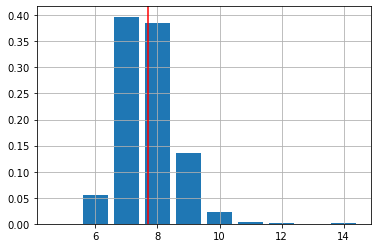

In [7]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [8]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,9.671361e-05
1,6,5.447798e-02
2,7,3.972332e-01
3,8,3.852478e-01
4,9,1.348747e-01
5,10,2.326011e-02
6,11,3.005445e-03
7,12,1.202466e-03
8,13,6.153792e-07
9,14,6.009349e-04
